In [ ]:
!python -V

In [1]:
import pandas as pd

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [ ]:
pd.__version__

In [2]:
!pip install pyarrow

In [3]:
# We call also ditrectly read the URL is we not downloadig locally. 
# https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet
df = pd.read_parquet('data/green_tripdata_2022-01.parquet')
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge'],
      dtype='object')

In [8]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2022-01-01 00:14:21,2022-01-01 00:15:33,N,1.0,42,42,1.0,0.44,3.5,0.50,0.5,0.00,0.0,None,0.3,4.80,2.0,1.0,0.00
1,1,2022-01-01 00:20:55,2022-01-01 00:29:38,N,1.0,116,41,1.0,2.10,9.5,0.50,0.5,0.00,0.0,None,0.3,10.80,2.0,1.0,0.00
2,1,2022-01-01 00:57:02,2022-01-01 01:13:14,N,1.0,41,140,1.0,3.70,14.5,3.25,0.5,4.60,0.0,None,0.3,23.15,1.0,1.0,2.75
3,2,2022-01-01 00:07:42,2022-01-01 00:15:57,N,1.0,181,181,1.0,1.69,8.0,0.50,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2022-01-01 00:07:50,2022-01-01 00:28:52,N,1.0,33,170,1.0,6.26,22.0,0.50,0.5,5.21,0.0,None,0.3,31.26,1.0,1.0,2.75


In [9]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [4]:
# Get the duration of the trip and convert to minutes
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [18]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [5]:
df[df['duration'] <= 0.0]["duration"].value_counts(bins=10)

(-0.0002, 0.0]        84
(-0.002, -0.0008]      0
(-0.0008, -0.0006]     0
(-0.0006, -0.0004]     0
(-0.0004, -0.0002]     0
(0.0, 0.0002]          0
(0.0002, 0.0004]       0
(0.0004, 0.0006]       0
(0.0006, 0.0008]       0
(0.0008, 0.001]        0
Name: duration, dtype: int64

In [6]:
# Consider only trips between 1 and 60 minutes
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [7]:
# Create the categorical and numerical features
# The IDs are stored as numbers
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str) # Dict vertorisers use one hot encoding for features that are of type "string"

In [8]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2022-01-01 00:14:21,2022-01-01 00:15:33,N,1.0,42,42,1.0,0.44,3.5,...,0.5,0.00,0.0,None,0.3,4.80,2.0,1.0,0.00,1.200000
1,1,2022-01-01 00:20:55,2022-01-01 00:29:38,N,1.0,116,41,1.0,2.10,9.5,...,0.5,0.00,0.0,None,0.3,10.80,2.0,1.0,0.00,8.716667
2,1,2022-01-01 00:57:02,2022-01-01 01:13:14,N,1.0,41,140,1.0,3.70,14.5,...,0.5,4.60,0.0,None,0.3,23.15,1.0,1.0,2.75,16.200000
3,2,2022-01-01 00:07:42,2022-01-01 00:15:57,N,1.0,181,181,1.0,1.69,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,8.250000
4,2,2022-01-01 00:07:50,2022-01-01 00:28:52,N,1.0,33,170,1.0,6.26,22.0,...,0.5,5.21,0.0,None,0.3,31.26,1.0,1.0,2.75,21.033333


In [9]:
# Create a dictionary of records that can be later processed using DictVectoriser (both categorial and numerical)
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [10]:
train_dicts

[{'PULocationID': '42', 'DOLocationID': '42', 'trip_distance': 0.44},
 {'PULocationID': '116', 'DOLocationID': '41', 'trip_distance': 2.1},
 {'PULocationID': '41', 'DOLocationID': '140', 'trip_distance': 3.7},
 {'PULocationID': '181', 'DOLocationID': '181', 'trip_distance': 1.69},
 {'PULocationID': '33', 'DOLocationID': '170', 'trip_distance': 6.26},
 {'PULocationID': '150', 'DOLocationID': '210', 'trip_distance': 1.3},
 {'PULocationID': '66', 'DOLocationID': '67', 'trip_distance': 6.47},
 {'PULocationID': '40', 'DOLocationID': '195', 'trip_distance': 1.15},
 {'PULocationID': '112', 'DOLocationID': '80', 'trip_distance': 1.3},
 {'PULocationID': '256', 'DOLocationID': '186', 'trip_distance': 4.75},
 {'PULocationID': '75', 'DOLocationID': '4', 'trip_distance': 6.03},
 {'PULocationID': '41', 'DOLocationID': '116', 'trip_distance': 2.82},
 {'PULocationID': '75', 'DOLocationID': '74', 'trip_distance': 0.7},
 {'PULocationID': '74', 'DOLocationID': '231', 'trip_distance': 7.54},
 {'PULocation

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

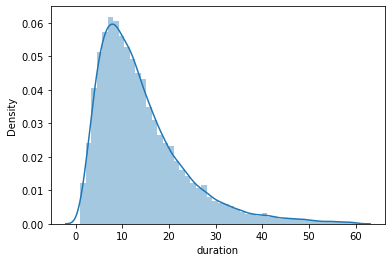

In [15]:
sns.distplot(df['duration'])

In [17]:
df['duration'].describe(percentiles=[.99, .98, .95])

count    59603.000000
mean        14.092953
std          9.438327
min          1.000000
50%         11.800000
95%         33.000000
98%         41.983333
99%         47.750000
max         60.000000
Name: duration, dtype: float64

In [18]:

# The purpose of a DictVectorizer is to create a new feature for each one hot encoded categorical value.
# No pre-processing will be done on numerical features
dv = DictVectorizer()

X_train = dv.fit_transform(train_dicts)

In [19]:
X_train # features matrix

<59603x471 sparse matrix of type '<class 'numpy.float64'>'
	with 178809 stored elements in Compressed Sparse Row format>

In [23]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',
 'DOLocationID=146',
 'DOLocationID=147',
 'DOLocationID=148',

In [24]:
dv

DictVectorizer()

In [25]:
# We will predict the trip duration based on the PU location, DO location and trip distance
target = 'duration'
y_train = df['duration'].values

In [26]:
y_train

array([ 1.2       ,  8.71666667, 16.2       , ..., 19.        ,
       10.        , 34.        ])

In [28]:
lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression()

In [29]:
y_pred = lr.predict(X_train)

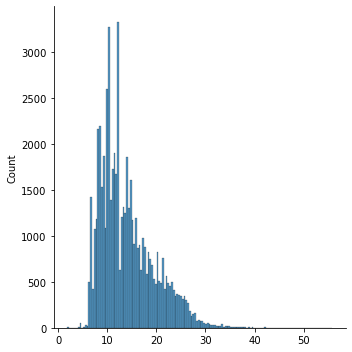

In [30]:
sns.displot(y_pred, label="Predictions")

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


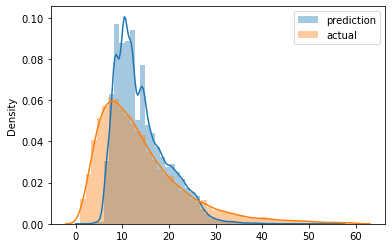

In [33]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [35]:
mean_squared_error(y_train, y_pred, squared = False)

7.652716560267797

In [36]:
# The above number indicates that the preicition is off by ~ 7 minutes from the actual duration
# Setting squared to False will return the RMSE. sklearn.metrics has a mean_squared_error function. 
# The RMSE is just the square root of whatever it returns.

In [37]:
# Function to create train and validation datasets and run different models on it

def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [38]:
# Jan, 2021 trips for training and Feb, 2021 for validation   
#df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
#df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [39]:
len(df_train), len(df_val)

(73908, 61921)

In [41]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [42]:
df_train['PU_DO'].head()

0     43_151
1    166_239
2      41_42
3     168_75
7      75_75
Name: PU_DO, dtype: object

In [44]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [45]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [46]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.479562160810692

In [49]:
# If you want to create a backup of the model

import pickle
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [50]:
lr = Lasso(alpha = 0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.167275941179728